In [1]:
import tensorflow as tf

In [2]:
import glob
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
parent = os.path.join(os.path.dirname(os.getcwd()), 'data')
weto_path = os.path.join(parent, 'weto', 'train')

### Load data

In [69]:
BATCH_SIZE = 8

train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=weto_path,
    label_mode = None,
    batch_size=BATCH_SIZE,
    seed=0,
    shuffle = True,
    output_sequence_length=48000)

train_ds.element_spec

Found 1345 files belonging to 1 classes.


TensorSpec(shape=(None, 48000, None), dtype=tf.float32, name=None)

In [70]:
#Dataset only contains one channel
#Remove the extra axis

def squeeze(audio):
  audio = tf.squeeze(audio, axis=-1)
  return audio

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)

for example_audio in train_ds.take(1):  
  print(example_audio.shape)

(8, 48000)


In [6]:
#Convert waveform to spectrogram

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=512, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [71]:
def get_square_spectrogram(waveform):
    spectrogram = get_spectrogram(waveform)
    cropped = tf.image.crop_to_bounding_box(image = spectrogram, 
                                            offset_height = 0, 
                                            offset_width = 0, 
                                            target_height = 372, 
                                            target_width = 257)
    square = tf.image.resize_with_pad(  image = cropped,
                                        target_height = 512,
                                        target_width = 512,
                                        #method=ResizeMethod.BILINEAR,
                                        antialias=False)
    return(square)

In [77]:
#Make spectrogram datasets

def make_spec_ds(ds):
  return ds.map(
      #map_func=lambda audio,label: (get_spectrogram(audio), label),
      map_func=lambda audio: (get_square_spectrogram(audio)),
      num_parallel_calls=tf.data.AUTOTUNE)

In [80]:
train_spectrogram_ds = make_spec_ds(train_ds)
for example_spectrograms in train_spectrogram_ds.take(1):
  break

spec_shape = example_spectrograms.shape[1:]
print(f"Spectrogram image shape: {spec_shape}")

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1100).prefetch(tf.data.AUTOTUNE)

Spectrogram image shape: (512, 512, 1)


In [83]:
example_spectrograms[0,5,5,0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Define Model

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((128, 128, 256)))
    assert model.output_shape == (None, 128, 128, 256)  # Note: None is the batch size

 #   model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
 #   assert model.output_shape == (None, 128, 128, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 256, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 512, 512, 1)

    return model

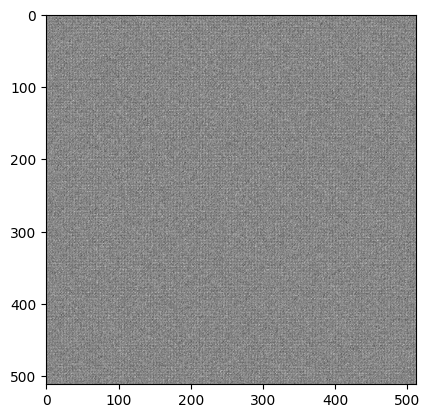

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[ 512, 512, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00011361]], shape=(1, 1), dtype=float32)


In [17]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define the training loop

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()



def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [30]:
example_spectrograms.shape

TensorShape([8, 512, 512, 1])

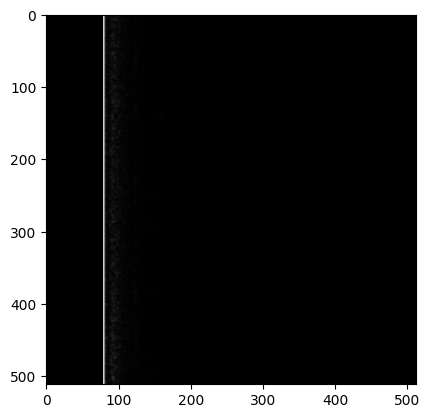

In [59]:
import tensorflow_io as tfio

test = tfio.audio.spectrogram(
    example_spectrograms[0], nfft = 500, window = 512, stride= 128, name=None
)

plt.imshow(example_spectrograms[0, :, :, 0] * 127.5 + 127.5, cmap='gray')

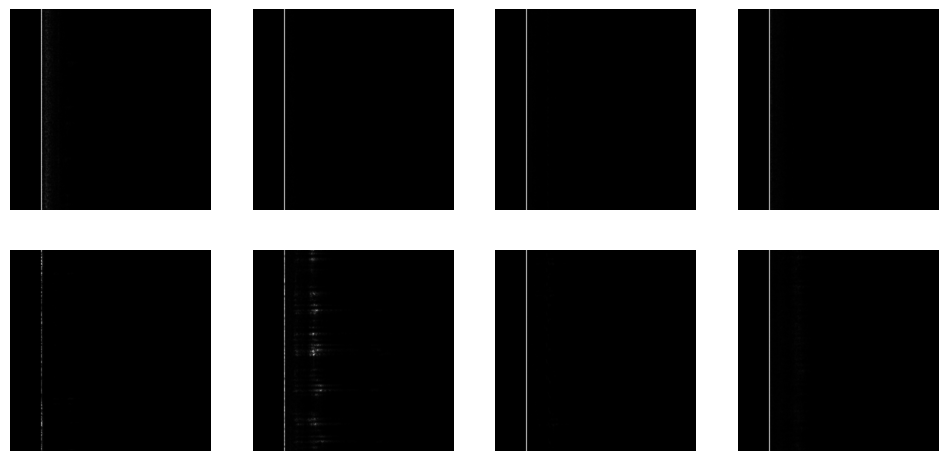

In [53]:
for example_spectrograms in train_spectrogram_ds.take(5):
    break

fig = plt.figure(figsize=(12, 12))

for i in range(example_spectrograms.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(example_spectrograms[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()

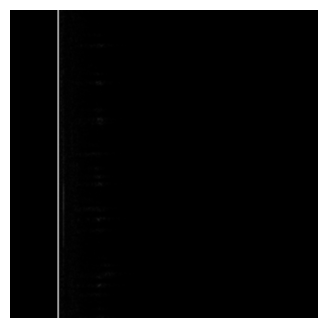

In [37]:
fig = plt.figure(figsize=(4, 4))


plt.imshow(example_spectrograms[2, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')

#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()

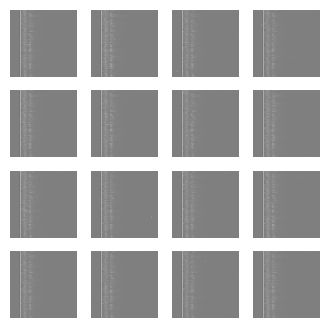

Time for epoch 45 is 119.84956049919128 sec


KeyboardInterrupt: 

In [23]:
train(train_spectrogram_ds, EPOCHS)